# 2.3.2 Rによる回帰分析の実行

In [66]:
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rdata
import seaborn as sns
import statsmodels.formula.api as smf

warnings.simplefilter("ignore")

## データの準備

In [2]:
parsed = rdata.parser.parse_file("vouchers.rda")
converted = rdata.conversion.convert(parsed)
vouchers = converted["vouchers"]

# bogota 1995のデータを抽出
data = vouchers.query("TAB3SMPL == 1 and BOG95SMP == 1")
data.shape

/Users/takumiwatanabe/github/takumiw/cibook-python/.venv/lib/python3.10/site-packages/rdata/conversion/_conversion.py:669: UserWarning: Missing constructor for R class "tbl_df". The constructor for class "tbl" will be used instead.
  warnings.warn(
/Users/takumiwatanabe/github/takumiw/cibook-python/.venv/lib/python3.10/site-packages/rdata/conversion/_conversion.py:669: UserWarning: Missing constructor for R class "tbl". The constructor for class "data.frame" will be used instead.
  warnings.warn(


(1147, 89)

In [3]:
data.head(3)

,ID,BOG95SMP,BOG97SMP,JAM93SMP,SEX,AGE,AGE2,HSVISIT,SCYFNSH,INSCHL,...,REPT,NREPT,FINISH6,FINISH7,FINISH8,SEX_MISS,USNGSCH,HOURSUM,TAB3SMPL,WORKING3
4,3.0,1.0,0.0,0.0,0.0,14.0,12.0,0.0,8.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
5,4.0,1.0,0.0,0.0,1.0,14.0,12.0,0.0,8.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
6,5.0,1.0,0.0,0.0,0.0,14.0,12.0,0.0,8.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


## 回帰分析
- treatmentの推定結果は 0.8100 であり、その検定におけるp値も 0.000 < 0.05 と非常に小さい値のため、帰無仮説 (メール送信の効果はない) を棄却できる
- 従って、この値はメールを送信することで売上が平均 0.8 ほど増加するという解釈が可能

In [4]:
formula_x_base = "VOUCH0"  # 介入変数
formula_x_covariate = [
    'SVY',  'HSVISIT', 'AGE', 'STRATA1', 'STRATA2', 'STRATA3', 'STRATA4', 'STRATA5', 'STRATA6', 'STRATAMS',
    'D1993', 'D1995', 'D1997',
    'DMONTH1', 'DMONTH2', 'DMONTH3', 'DMONTH4', 'DMONTH5', 'DMONTH6', 'DMONTH7', 'DMONTH8', 'DMONTH9', 'DMONTH10', 'DMONTH11', 'DMONTH12', 
    'SEX2'
]  # 共変量
formula_ys = [
    'TOTSCYRS','INSCHL','PRSCH_C','USNGSCH','PRSCHA_1','FINISH6','FINISH7',
    'FINISH8','REPT6','REPT','NREPT', 'MARRIED','HASCHILD','HOURSUM','WORKING3'
]  # 被目的変数の候補

In [5]:
# 被目的変数の各候補に対して、共変量を含まない回帰式の作成
base_reg_formulas = [f"{y} ~ {formula_x_base}" for y in formula_ys]
base_reg_formulas[0]

'TOTSCYRS ~ VOUCH0'

In [6]:
# 被目的変数の各候補に対して、共変量を含む回帰式の作成
covariate_reg_formulas = [f"{y} ~ {' + '.join([formula_x_base] + formula_x_covariate)}" for y in formula_ys]
covariate_reg_formulas[0]

'TOTSCYRS ~ VOUCH0 + SVY + HSVISIT + AGE + STRATA1 + STRATA2 + STRATA3 + STRATA4 + STRATA5 + STRATA6 + STRATAMS + D1993 + D1995 + D1997 + DMONTH1 + DMONTH2 + DMONTH3 + DMONTH4 + DMONTH5 + DMONTH6 + DMONTH7 + DMONTH8 + DMONTH9 + DMONTH10 + DMONTH11 + DMONTH12 + SEX2'

In [7]:
# 回帰分析を実行
z = "VOUCH0"
result = pd.DataFrame(columns=["model_index", "term", "estimate", "std_error", "p_value", "ci_lower", "ci_upper"])

# 共変量を含まない場合と含む場合について実行
for formulas, covar in zip([base_reg_formulas, covariate_reg_formulas], ["base", "covariate"]):
    # 各回帰式を実行
    for formula in formulas:
        y = "_".join([formula.split(" ~ ")[0], covar])
        reg = smf.ols(data=data, formula=formula).fit()
        reg_summary = pd.read_html(reg.summary().tables[1].as_html(), header=0, index_col=0)[0]
        est = reg_summary.loc["VOUCH0", "coef"]
        std_error = reg_summary.loc["VOUCH0", "std err"]
        p = reg_summary.loc["VOUCH0", "P>|t|"]
        ci_lower = reg_summary.loc["VOUCH0", "[0.025"]
        ci_upper = reg_summary.loc["VOUCH0", "0.975]"]
        reg_result = {"model_index": y, "term": z, "estimate": est, "std_error": std_error, "p_value": p, "ci_lower": ci_lower, "ci_upper": ci_upper}
        result = pd.concat([result, pd.DataFrame.from_dict(reg_result, orient='index').T])
    
result = result.reset_index(drop=True)

In [8]:
result.head()

,model_index,term,estimate,std_error,p_value,ci_lower,ci_upper
0,TOTSCYRS_base,VOUCH0,0.0581,0.052,0.267,-0.045,0.161
1,INSCHL_base,VOUCH0,0.0186,0.022,0.39,-0.024,0.061
2,PRSCH_C_base,VOUCH0,0.16,0.028,0.0,0.104,0.216
3,USNGSCH_base,VOUCH0,0.5089,0.023,0.0,0.464,0.554
4,PRSCHA_1_base,VOUCH0,0.0629,0.017,0.0,0.03,0.096


In [9]:
result.tail()

,model_index,term,estimate,std_error,p_value,ci_lower,ci_upper
25,NREPT_covariate,VOUCH0,-0.0667,0.028,0.017,-0.122,-0.012
26,MARRIED_covariate,VOUCH0,-0.0087,0.006,0.162,-0.021,0.004
27,HASCHILD_covariate,VOUCH0,-0.0103,0.01,0.286,-0.029,0.009
28,HOURSUM_covariate,VOUCH0,-1.2223,0.636,0.055,-2.47,0.025
29,WORKING3_covariate,VOUCH0,-0.0297,0.02,0.146,-0.07,0.01


# 2.3.3 私立学校への通学と割引券の利用についての分析

## 当選したグループで割引券がちゃんと利用されたかを確認
6年生の開始時に私立学校に在籍していたかを示す "PRSCHA_1" と、調査期間中に何かしらの奨学金を使ったかを示す "USNGSCH" に対する回帰分析の結果を参照する  
当選グループにおいて、私立学校で6年生を始める比率が 6% 増加 (87% → 93%)  
- 非当選グループでも87%程度の生徒が6年生を私立学校でスタートしている
- くじに当たってもはずれても、結局私立学校へ通う生徒が多いことを示す
- → 実験参加の申請の条件に私立学校の入学許可の提出が含まれていることが理由であると考えられる
- → 既に入学する確率が高い状態の生徒の間で介入をランダムにアサインしている
- →　当選してもしなくても生徒が受ける教育の質は短期的には大きく変わらないことを意味しており、今後の分析で学力などに効果が確認できても、その効果は学習の環境を短期的に変えたことで生まれるわけではないことを示唆する。

当選グループにおいて、何かしらの奨学金を使った比率が 50% 増加 (5% → 55%)  
- 当選したことにより、多くの生徒が割引券を利用し続けていることがわかる
  
以上の結果から、割引券自体は当選グループでちゃんと使われているものの、そもそもの私立学校への通学率が高いために通学率での効果が限定的になっていることがわかる。  
少なくともこのデータでは、割引券には私立学校へ"通わせ始める"効果はかくにんされなかったということになる

In [10]:
result_ = result[result.model_index.str.contains("PRSCHA_1") | result.model_index.str.contains("USNGSCH")].sort_values(by="model_index")
result_

,model_index,term,estimate,std_error,p_value,ci_lower,ci_upper
4,PRSCHA_1_base,VOUCH0,0.0629,0.017,0.0,0.03,0.096
19,PRSCHA_1_covariate,VOUCH0,0.0574,0.017,0.001,0.024,0.091
3,USNGSCH_base,VOUCH0,0.5089,0.023,0.0,0.464,0.554
18,USNGSCH_covariate,VOUCH0,0.5042,0.023,0.0,0.459,0.549


# 2.3.4 割引券は留年を減らしているか？
当選から3年経過した調査段階において、まだ私立学校へ通っていることを表す変数 "PRSCHC_C" に対する回帰分析の結果  
- 通っている場合は1, そうでない場合には0を取るところ、効果量は0.15程度となり、当選したことによって私立へ通い続ける精度が15%程度増加している事がわかる  

6年生で留年をしたかを示すREPT6の推定結果は-0.06であり、当選グループでは6年生における留年する確率が6%程度低いことを示している。  
→ 当選することで私立学校へ継続的に通学できるようになり、それは割引券による学費の低下とそれを維持し続けるために留年しなくなった生徒がいるという状況がありそう。  

この結果は、割引券を受け取った生徒がより学費が高く教育の質が高い学校へ行ったために留学しなくなったということに起因しているとも考えられる。  
しかし、各生徒と学校選択についてのデータがないため、この要因の切り分けはできない。  
よって、留年しなくなる理由が割引券のインセンティブ設計にあるのかをこのデータで完全に明らかにすることはできない。

In [11]:
result[result.model_index.str.contains("covariate")].model_index.unique()

array(['TOTSCYRS_covariate', 'INSCHL_covariate', 'PRSCH_C_covariate',
       'USNGSCH_covariate', 'PRSCHA_1_covariate', 'FINISH6_covariate',
       'FINISH7_covariate', 'FINISH8_covariate', 'REPT6_covariate',
       'REPT_covariate', 'NREPT_covariate', 'MARRIED_covariate',
       'HASCHILD_covariate', 'HOURSUM_covariate', 'WORKING3_covariate'],
      dtype=object)

In [13]:
result_ = result[result.model_index.isin([
    "FINISH6_covariate", "FINISH7_covariate", "FINISH8_covariate", "INSCHL_covariate", "PRSCH_C_covariate", "REPT_covariate", "REPT6_covariate"
])].sort_values(by="model_index").reset_index(drop=True)
result_

,model_index,term,estimate,std_error,p_value,ci_lower,ci_upper
0,FINISH6_covariate,VOUCH0,0.0229,0.012,0.056,-0.001,0.047
1,FINISH7_covariate,VOUCH0,0.0307,0.02,0.12,-0.008,0.07
2,FINISH8_covariate,VOUCH0,0.1002,0.027,0.0,0.047,0.153
3,INSCHL_covariate,VOUCH0,0.0069,0.02,0.734,-0.033,0.047
4,PRSCH_C_covariate,VOUCH0,0.1533,0.028,0.0,0.099,0.208
5,REPT6_covariate,VOUCH0,-0.0594,0.025,0.016,-0.108,-0.011
6,REPT_covariate,VOUCH0,-0.0548,0.024,0.02,-0.101,-0.009


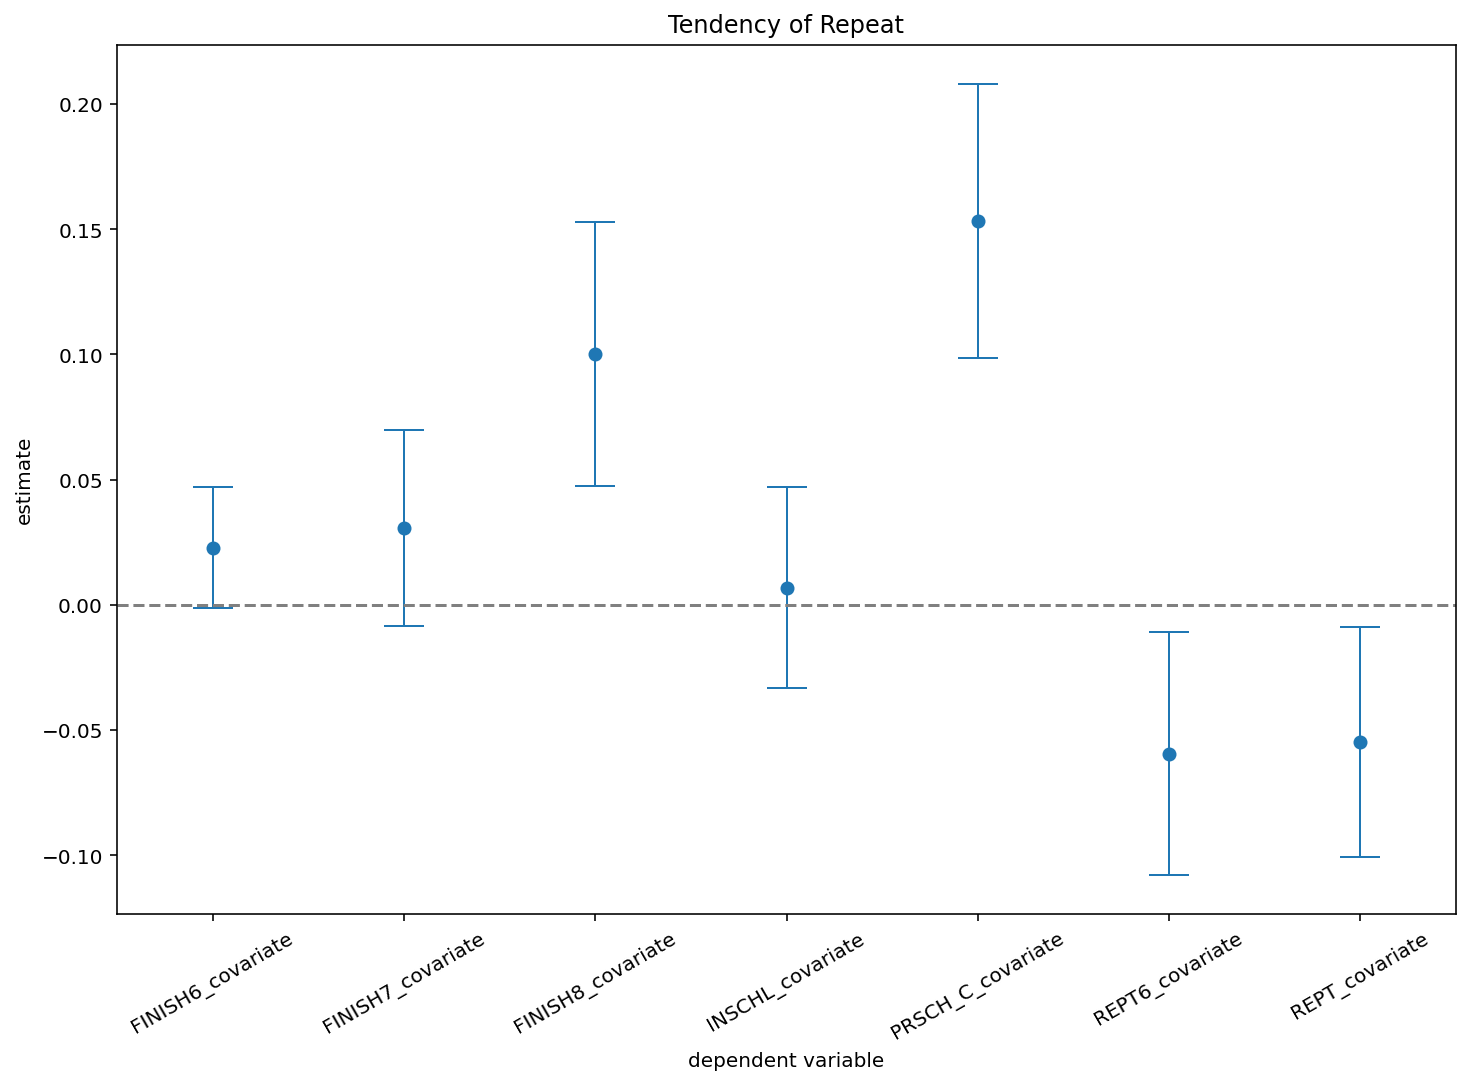

In [67]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(result_.model_index, result_.estimate, yerr=(result_.ci_upper-result_.estimate), marker='o', capthick=1, capsize=10, lw=1, linestyle="")
ax.hlines(0.0, xmin=-0.5, xmax=6.5, linestyles="dashed", color="gray")
ax.set(xlabel="dependent variable", ylabel="estimate", xlim=[-0.5, 6.5])
ax.set_xticklabels(result_.model_index, rotation=30)
plt.title("Tendency of Repeat")
plt.show()

# 2.3.5 性別による効果差
介入の割り振りが行われた年における私立学校への通学率は、男子生徒は9%程度の効果があったと示してる  
女子生徒は2%程度という結果となっているが統計亭な有意差がなく、私立学校へ通わせる効果はないという可能性を否定しきれないことになる  

奨学金の利用を示すUSNGSCHに対する結果では、男子生徒では46%程度の効果があることを示唆しているが、女子生徒では55%程度の効果となっている  
よって、女子生徒のほうが当選した際に奨学金を利用する傾向が強いことがわかる

In [73]:
formula_x_base = "VOUCH0"  # 介入変数
formula_x_covariate = [
    'SVY',  'HSVISIT', 'AGE', 'STRATA1', 'STRATA2', 'STRATA3', 'STRATA4', 'STRATA5', 'STRATA6', 'STRATAMS',
    'D1993', 'D1995', 'D1997',
    'DMONTH1', 'DMONTH2', 'DMONTH3', 'DMONTH4', 'DMONTH5', 'DMONTH6', 'DMONTH7', 'DMONTH8', 'DMONTH9', 'DMONTH10', 'DMONTH11', 'DMONTH12'
]  # 共変量
formula_ys = ['USNGSCH','PRSCHA_1']  # 被目的変数の候補

In [74]:
# 被目的変数の各候補に対して、共変量を含む回帰式の作成
covariate_reg_formulas = [f"{y} ~ {' + '.join([formula_x_base] + formula_x_covariate)}" for y in formula_ys]
covariate_reg_formulas[0]

'USNGSCH ~ VOUCH0 + SVY + HSVISIT + AGE + STRATA1 + STRATA2 + STRATA3 + STRATA4 + STRATA5 + STRATA6 + STRATAMS + D1993 + D1995 + D1997 + DMONTH1 + DMONTH2 + DMONTH3 + DMONTH4 + DMONTH5 + DMONTH6 + DMONTH7 + DMONTH8 + DMONTH9 + DMONTH10 + DMONTH11 + DMONTH12'

In [79]:
# 回帰分析を実行
z = "VOUCH0"
covar = "covariate"
result_male = pd.DataFrame(columns=["model_index", "term", "estimate", "std_error", "p_value", "ci_lower", "ci_upper"])
result_female = pd.DataFrame(columns=["model_index", "term", "estimate", "std_error", "p_value", "ci_lower", "ci_upper"])

# 共変量を含まない場合と含む場合について実行
for gender_cd in [0, 1]:
    for formula in covariate_reg_formulas:
        y = "_".join([formula.split(" ~ ")[0], covar])
        reg = smf.ols(data=data.query("SEX2 == @gender_cd"), formula=formula).fit()
        reg_summary = pd.read_html(reg.summary().tables[1].as_html(), header=0, index_col=0)[0]
        est = reg_summary.loc["VOUCH0", "coef"]
        std_error = reg_summary.loc["VOUCH0", "std err"]
        p = reg_summary.loc["VOUCH0", "P>|t|"]
        ci_lower = reg_summary.loc["VOUCH0", "[0.025"]
        ci_upper = reg_summary.loc["VOUCH0", "0.975]"]
        reg_result = {"model_index": y, "term": z, "estimate": est, "std_error": std_error, "p_value": p, "ci_lower": ci_lower, "ci_upper": ci_upper}
        if gender_cd == 0:
            result_female = pd.concat([result_female, pd.DataFrame.from_dict(reg_result, orient='index').T])
        else:
            result_male = pd.concat([result_male, pd.DataFrame.from_dict(reg_result, orient='index').T])
    
result_male = result_male.reset_index(drop=True)
result_female = result_female.reset_index(drop=True)

In [80]:
result_male

,model_index,term,estimate,std_error,p_value,ci_lower,ci_upper
0,USNGSCH_covariate,VOUCH0,0.4677,0.033,0.0,0.403,0.533
1,PRSCHA_1_covariate,VOUCH0,0.0902,0.025,0.0,0.04,0.14


In [81]:
result_female

,model_index,term,estimate,std_error,p_value,ci_lower,ci_upper
0,USNGSCH_covariate,VOUCH0,0.5436,0.032,0.0,0.481,0.606
1,PRSCHA_1_covariate,VOUCH0,0.0229,0.023,0.312,-0.022,0.067


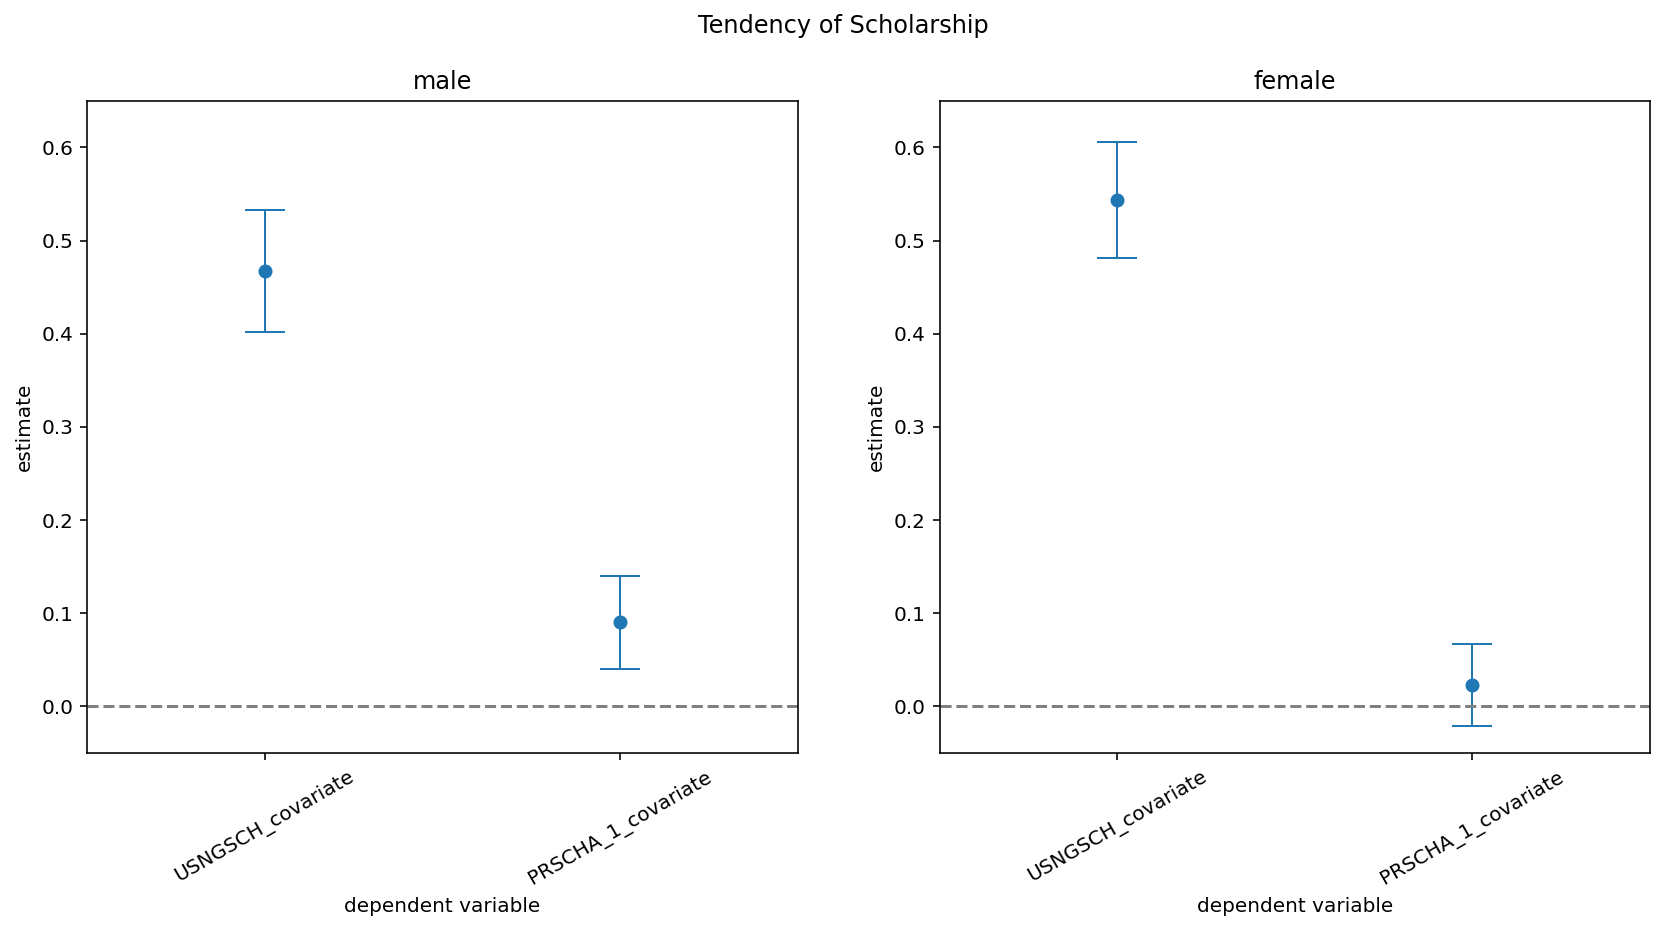

In [91]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
for ax_, gender_, result_ in zip(ax, ["male", "female"], [result_male, result_female]):
    ax_.errorbar(result_.model_index, result_.estimate, yerr=(result_.ci_upper-result_.estimate), marker='o', capthick=1, capsize=10, lw=1, linestyle="")
    ax_.hlines(0.0, xmin=-0.5, xmax=1.5, linestyles="dashed", color="gray")
    ax_.set(xlabel="dependent variable", ylabel="estimate", xlim=[-0.5, 1.5], ylim=[-0.05, 0.65], title=gender_)
    ax_.set_xticklabels(result_.model_index, rotation=30)

plt.suptitle("Tendency of Scholarship")
plt.show()